In [5]:
!pip install numpy

   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   ---------- ----------------------------- 3.9/14.9 MB 18.1 MB/s eta 0:00:01
   -------------------- ------------------- 7.6/14.9 MB 18.1 MB/s eta 0:00:01
   ------------------------------- -------- 11.5/14.9 MB 18.0 MB/s eta 0:00:01
   ---------------------------------------- 14.9/14.9 MB 17.6 MB/s eta 0:00:00


In [8]:
pip install Pillow


   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 16.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install scikit-learn


   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   --------------- ------------------------ 3.7/9.3 MB 19.8 MB/s eta 0:00:01
   ------------------------------- -------- 7.3/9.3 MB 18.9 MB/s eta 0:00:01
   ---------------------------------------- 9.3/9.3 MB 18.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/42.2 MB ? eta -:--:--
   --- ------------------------------------ 3.9/42.2 MB 18.0 MB/s eta 0:00:03
   ------- -------------------------------- 7.6/42.2 MB 18.0 MB/s eta 0:00:02
   ---------- ----------------------------- 11.5/42.2 MB 18.0 MB/s eta 0:00:02
   -------------- ------------------------- 15.5/42.2 MB 18.7 MB/s eta 0:00:02
   ------------------ --------------------- 19.4/42.2 MB 18.5 MB/s eta 0:00:02
   ---------------------- ----------------- 23.3/42.2 MB 18.5 MB/s eta 0:00:02
   ------------------------- -------------- 27.0/42.2 MB 18.4 MB/s eta 0:00:01
   ----------------------------- ---------- 30.9/42.2 MB 18.3 MB/s eta 0:00:01


In [11]:
pip install tensorflow


INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
    --------------------------------------- 3.7/276.5 MB 18.1 MB/s eta 0:00:16
   - -------------------------------------- 7.3/276.5 MB 18.9 MB/s eta 0:00:15
   - -------------------------------------- 11.5/276.5 MB 19.0 MB/s eta 0:00:14
   -- ------------------------------------- 15.2/276.5 MB 18.7 MB/s eta 0:00:14
   -- ------------------------------------- 19.1/276.5 MB 18.6 MB/s eta 0:00:14
   --- ------------------------------------ 23.1/276.5 MB 18.5 MB/s eta 0:00:14
   --- ------------------------------------ 27.0/276.5 MB 18.6 MB/s eta 0:00:14
   ---- ----------------------------------- 30.9/276.5 MB 18.7 MB/s eta 0:00:14
   ----- ---------------------------------- 34.9/276.5 MB 18.6 MB/s eta 0:00:13
   ----- ---------------------------------- 38.5/276.5 MB 18.6 M

  You can safely remove it manually.


In [1]:
import os
import time
import numpy as np
import psutil
from PIL import Image
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

def resize_image(img, size):
    """Resize image to the given size."""
    return img.resize(size)

def convert_to_rgb(img):
    """Convert image to RGB mode."""
    return img.convert('RGB')

def preprocess_image(img, target_size):
    """Preprocess image for Xception model."""
    img = img.resize(target_size)
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def create_custom_xception_model():
    """Create a customized Xception model."""
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer
    predictions = Dense(128, activation='relu')(x)

    # Create and return the model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def load_custom_model():
    """Load the customized Xception model."""
    return create_custom_xception_model()

def extract_features(img, model):
    """Extract features using the customized Xception model."""
    return model.predict(img)

def measure_memory_usage():
    """Measure the current memory usage of the process."""
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
    return memory_usage

def find_duplicate_images(folder, model, target_size=(299, 299)):
    """Find duplicate images in a folder based on feature similarity."""
    
    feature_list = []
    file_paths = []

    # Traverse the directory
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        rgb_img = convert_to_rgb(img)
                        preprocessed_img = preprocess_image(rgb_img, target_size)
                    img_features = extract_features(preprocessed_img, model).flatten()
                    
                    feature_list.append(img_features)
                    file_paths.append(file_path)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    # Normalize features and reduce dimensionality
    feature_list = np.array(feature_list)
    pca = PCA(n_components=50)  # Reduce dimensions to 50 components
    reduced_features = pca.fit_transform(feature_list)

    # Calculate cosine similarity between feature vectors
    similarity_matrix = cosine_similarity(reduced_features)
    threshold = 0.9  # Adjust this threshold based on your needs
    
    # Identify duplicates based on similarity
    duplicates = []
    visited = set()
    
    for i in range(len(file_paths)):
        if i in visited:
            continue
        group = [file_paths[i]]
        visited.add(i)
        for j in range(i + 1, len(file_paths)):
            if similarity_matrix[i, j] > threshold:
                group.append(file_paths[j])
                visited.add(j)
        if len(group) > 1:
            duplicates.append(group)

    return duplicates

if __name__ == "__main__":
    folder_path = r'C:\Users\uu1n23\Downloads\DeduplicationFinal'
    
    model = load_custom_model()
    
    memory_before = measure_memory_usage()
    
    start_time = time.time()
    duplicate_pairs = find_duplicate_images(folder_path, model)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    memory_after = measure_memory_usage()
    memory_used = memory_after - memory_before
    
    print(f"Time taken: {elapsed_time:.2f} seconds")
    print(f"Memory used: {memory_used:.2f} MB")

    print("Duplicate image groups:")
    for group in duplicate_pairs:
        print(group)


1/1 [==============================] - 0s 99ms/step


c:\Users\uu1n23\OneDrive - University of Southampton\Desktop\hsshing\.venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


1/1 [==============================] - 0s 84ms/step


c:\Users\uu1n23\OneDrive - University of Southampton\Desktop\hsshing\.venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1/1 [==============================] - 0s 89ms/step
Time taken: 143.09 seconds
Memory used: 373.55 MB
Duplicate image groups:
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_006_74.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\RMM 1974_6.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_006_74.tif']
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_008_71.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_008_71 - Copy.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_008_71.tif']
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_008_74.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\RMM 1974_8.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_008_74.tif']
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_009_74.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_009_74.tif']
['C:\\Users\\uu1n23\\Downloads\\Dedu

In [2]:
def calculate_accuracy(ground_truth, duplicate_pairs):
    # Convert ground truth pairs to a set of tuples without paths
    ground_truth_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in ground_truth)
    
    # Convert detected pairs to a set of tuples without paths
    detected_pairs_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in duplicate_pairs)
    
    # Calculate intersection (common pairs)
    common_pairs = ground_truth_set.intersection(detected_pairs_set)
    
    # Calculate accuracy as the ratio of correctly detected pairs to total ground truth pairs
    accuracy = len(common_pairs) / len(ground_truth)
    
    return accuracy
if __name__ == "__main__":
    # Your ground truth pairs
    ground_truth =  [
    ('hmp_rmmus_011_74.tif', 'RMM 1974_11.tif'),
    ('RMM 1974_13.tif', 'RMM 1974_13_o2.jpg'),
    ('hmp_rmmus_006_74.tif', 'RMM 1974_6.tif'),
    ('RMM 1974_7.tif', 'RMM 1974_7_o4.jpg'),
    ('hmp_rmmus_008_74.tif', 'RMM 1974_8.tif'),
    ('hmp_rmmus_006_74.tif', 'hmp_rmmus_006_74.tif'),
    ('RMM 1974_7.tif', 'hmp_rmmus_007_74.tif'),
    ('hmp_rmmus_008_71.tif', 'hmp_rmmus_008_71 - Copy.tif'),
    ('hmp_rmmus_008_71.tif', 'hmp_rmmus_008_71.tif'),
    ('hmp_rmmus_008_74.tif', 'hmp_rmmus_008_74.tif'),
    ('hmp_rmmus_009_74.tif', 'hmp_rmmus_009_74.tif'),
    ('hmp_rmmus_010_74.tif', 'hmp_rmmus_010_74.tif'),
    ('hmp_rmmus_011_74.tif', 'hmp_rmmus_011_74.tif'),
    ('RMM 1974_13.tif', 'hmp_rmmus_13_74.tif'),
    ('RMM 1973_170.tif', 'hmp_rmmus_170_73.tif'),
    ('RMM 1974_19.tif', 'hmp_rmmus_19_74.tif'),
    ('RMM 1974_20.tif', 'hmp_rmmus_20_74.tif'),
    ('RMM 1971_278.tif', 'hmp_rmmus_278_71.tif'),
    ('RMM 1967_304.tif', 'hmp_rmmus_304_67.tif'),
    ('hmp_rmmus_88_02o - Copy.tif', 'hmp_rmmus_88_02o.tif'),
    ('hmp_rmmus_88_02t.tif', 'hmp_rmmus_88_02ta.tif'),
    ('NMRN  2017_106_178_unframed.jpg', 'NMRN  2017_106_178_unframed.tif'),
    ('NMRN 2016_26_5 Commander Daniel Little Couch.jpg', 'NMRN 2016_26_5 Commander Daniel Little Couch.tif'),
    ('NMRN 2016_29_1 Cdr Crooke RNR low res.jpg', 'NMRN 2016_29_1 Cdr Crooke RNR.jpg'),
    ('RNM 1982_1572 - Copy.tif', 'RNM 1982_1572.tif'),
    ('RNM 2000_45_1 - Copy.tif', 'RNM 2000_45_1.tif'),
    ('Cardiff - Copy.jpg', 'Cardiff.jpg'),
    ('Exeter(2) - Copy.jpg', 'Exeter(2).jpg'),
    ('Exeter(8) - Copy.jpg', 'Exeter(8).jpg'),
    ('Glasgow(1) - Copy.jpg', 'Glasgow(1).jpg'),
    ('Black Rover(4).jpg', 'Black Rover(4).jpg'),
    ('Regent(3).jpg', 'Regent(3).jpg'),
    ('Achiles(1) - Copy.jpg', 'Achiles(1).jpg'),
    ('Phoebe(1) - Copy.jpg', 'Phoebe(1).jpg'),
    ('Sirius(2).jpg', 'Sirius(2).jpg'),
    ('Sirius(5) - Copy.jpg', 'Sirius(5).jpg'),
    ('Theseus.jpg', 'Theseus.jpg'),
    ('St Austell.jpg', 'St Austell.jpg'),
    ('London(1) - Copy.jpg', 'London(1).jpg'),
    ('Sheffield(6) - Copy.jpg', 'Sheffield(6).jpg'),
    ('Fearless.jpg', 'Fearless.jpg'),
    ('Lynx-1.jpg', 'Lynx-1.jpg'),
    ('Argus-1.jpg', 'Argus-1.jpg'),
    ('Brinton.jpg', 'Brinton.jpg'),
    ('Active-1.jpg', 'Amazon-1.jpg'),
    ('Exeter-2.jpg', 'Liverpool-2.jpg'),
    ('Sheffield-1.jpg', 'Sheffield-1.jpg'),
    ('Bangor - Copy.jpg', 'Bangor - Copy.jpg'),
    ('Bangor - Copy.jpg', 'Bangor.jpg'),
    ('Cumberland.jpg', 'Cumberland.jpg'),
    ('Gloucester.jpg', 'Gloucester.jpg')
]
# Calculate accuracy
accuracy = calculate_accuracy(ground_truth, duplicate_pairs)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 82.35%


In [3]:
ground_truth =  [
    ('hmp_rmmus_011_74.tif', 'RMM 1974_11.tif'),
    ('RMM 1974_13.tif', 'RMM 1974_13_o2.jpg'),
    ('hmp_rmmus_006_74.tif', 'RMM 1974_6.tif'),
    ('RMM 1974_7.tif', 'RMM 1974_7_o4.jpg'),
    ('hmp_rmmus_008_74.tif', 'RMM 1974_8.tif'),
    ('hmp_rmmus_006_74.tif', 'hmp_rmmus_006_74.tif'),
    ('RMM 1974_7.tif', 'hmp_rmmus_007_74.tif'),
    ('hmp_rmmus_008_71.tif', 'hmp_rmmus_008_71 - Copy.tif'),
    ('hmp_rmmus_008_71.tif', 'hmp_rmmus_008_71.tif'),
    ('hmp_rmmus_008_74.tif', 'hmp_rmmus_008_74.tif'),
    ('hmp_rmmus_009_74.tif', 'hmp_rmmus_009_74.tif'),
    ('hmp_rmmus_010_74.tif', 'hmp_rmmus_010_74.tif'),
    ('hmp_rmmus_011_74.tif', 'hmp_rmmus_011_74.tif'),
    ('RMM 1974_13.tif', 'hmp_rmmus_13_74.tif'),
    ('RMM 1973_170.tif', 'hmp_rmmus_170_73.tif'),
    ('RMM 1974_19.tif', 'hmp_rmmus_19_74.tif'),
    ('RMM 1974_20.tif', 'hmp_rmmus_20_74.tif'),
    ('RMM 1971_278.tif', 'hmp_rmmus_278_71.tif'),
    ('RMM 1967_304.tif', 'hmp_rmmus_304_67.tif'),
    ('hmp_rmmus_88_02o - Copy.tif', 'hmp_rmmus_88_02o.tif'),
    ('hmp_rmmus_88_02t.tif', 'hmp_rmmus_88_02ta.tif'),
    ('NMRN  2017_106_178_unframed.jpg', 'NMRN  2017_106_178_unframed.tif'),
    ('NMRN 2016_26_5 Commander Daniel Little Couch.jpg', 'NMRN 2016_26_5 Commander Daniel Little Couch.tif'),
    ('NMRN 2016_29_1 Cdr Crooke RNR low res.jpg', 'NMRN 2016_29_1 Cdr Crooke RNR.jpg'),
    ('RNM 1982_1572 - Copy.tif', 'RNM 1982_1572.tif'),
    ('RNM 2000_45_1 - Copy.tif', 'RNM 2000_45_1.tif'),
    ('Cardiff - Copy.jpg', 'Cardiff.jpg'),
    ('Exeter(2) - Copy.jpg', 'Exeter(2).jpg'),
    ('Exeter(8) - Copy.jpg', 'Exeter(8).jpg'),
    ('Glasgow(1) - Copy.jpg', 'Glasgow(1).jpg'),
    ('Black Rover(4).jpg', 'Black Rover(4).jpg'),
    ('Regent(3).jpg', 'Regent(3).jpg'),
    ('Achiles(1) - Copy.jpg', 'Achiles(1).jpg'),
    ('Phoebe(1) - Copy.jpg', 'Phoebe(1).jpg'),
    ('Sirius(2).jpg', 'Sirius(2).jpg'),
    ('Sirius(5) - Copy.jpg', 'Sirius(5).jpg'),
    ('Theseus.jpg', 'Theseus.jpg'),
    ('St Austell.jpg', 'St Austell.jpg'),
    ('London(1) - Copy.jpg', 'London(1).jpg'),
    ('Sheffield(6) - Copy.jpg', 'Sheffield(6).jpg'),
    ('Fearless.jpg', 'Fearless.jpg'),
    ('Lynx-1.jpg', 'Lynx-1.jpg'),
    ('Argus-1.jpg', 'Argus-1.jpg'),
    ('Brinton.jpg', 'Brinton.jpg'),
    ('Active-1.jpg', 'Amazon-1.jpg'),
    ('Exeter-2.jpg', 'Liverpool-2.jpg'),
    ('Sheffield-1.jpg', 'Sheffield-1.jpg'),
    ('Bangor - Copy.jpg', 'Bangor - Copy.jpg'),
    ('Bangor - Copy.jpg', 'Bangor.jpg'),
    ('Cumberland.jpg', 'Cumberland.jpg'),
    ('Gloucester.jpg', 'Gloucester.jpg')
]

In [4]:
from sklearn.metrics import jaccard_score

def calculate_jaccard_index(ground_truth, duplicate_pairs):
    ground_truth_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in ground_truth)
    detected_pairs_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in duplicate_pairs)
    
    y_true = []
    y_pred = []

    for pair in ground_truth_set:
        y_true.append(1)
        y_pred.append(1 if pair in detected_pairs_set else 0)
    
    for pair in detected_pairs_set - ground_truth_set:
        y_true.append(0)
        y_pred.append(1)
    
    jaccard = jaccard_score(y_true, y_pred)
    return jaccard

jaccard_index = calculate_jaccard_index(ground_truth, duplicate_pairs)
print(f"Jaccard Index: {jaccard_index:.2f}")


Jaccard Index: 0.74


In [5]:
def calculate_precision(duplicate_pairs, ground_truth):
    detected_pairs_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in duplicate_pairs)
    ground_truth_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in ground_truth)
    # Convert lists of duplicate pairs into sets of tuples (to handle unordered pairs)
    identified_set = set()
    for group in detected_pairs_set:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                identified_set.add(tuple(sorted([group[i], group[j]])))

    ground_truth_set = set()
    for group in ground_truth:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                ground_truth_set.add(tuple(sorted([group[i], group[j]])))

    # Calculate the number of correct predictions
    true_positives = identified_set.intersection(ground_truth_set)

    # Calculate precision
    precision = len(true_positives) / len(identified_set) if identified_set else 0

    return precision

# Example usage
precision = calculate_precision(duplicate_pairs, ground_truth)
print(f"Precision: {precision:.2f}")


Precision: 0.88


In [6]:
import os

def calculate_recall(duplicate_pairs, ground_truth):
    detected_pairs_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in duplicate_pairs)
    ground_truth_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in ground_truth)
    # Convert lists of duplicate pairs into sets of tuples (to handle unordered pairs)
    identified_set = set()
    for group in detected_pairs_set:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                identified_set.add(tuple(sorted([group[i], group[j]])))

    ground_truth_set = set()
    for group in ground_truth:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                ground_truth_set.add(tuple(sorted([group[i], group[j]])))

    # Calculate the number of correct predictions
    true_positives = identified_set.intersection(ground_truth_set)

    # Calculate recall
    recall = len(true_positives) / len(ground_truth_set) if ground_truth_set else 0

    return recall

# Example usage
recall = calculate_recall(duplicate_pairs, ground_truth)
print(f"Recall: {recall:.2f}")


Recall: 0.82


In [7]:
def calculate_f1_score(duplicate_pairs, ground_truth):
    precision = calculate_precision(duplicate_pairs, ground_truth)
    recall = calculate_recall(duplicate_pairs, ground_truth)

    # Calculate F1 Score
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

# Example usage
f1_score = calculate_f1_score(duplicate_pairs, ground_truth)
print(f"F1 Score: {f1_score:.2f}")


F1 Score: 0.85


LINE BY LINE

import os
import time
import numpy as np
import psutil
from PIL import Image
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
pip install seaborn

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ------------- -------------------------- 3.7/10.8 MB 19.8 MB/s eta 0:00:01
   ---------------------------- ----------- 7.6/10.8 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------- 10.8/10.8 MB 18.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import time
import numpy as np
import psutil
from PIL import Image
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
def resize_image(img, size):
    """Resize image to the given size."""
    return img.resize(size)

def convert_to_rgb(img):
    """Convert image to RGB mode."""
    return img.convert('RGB')

def preprocess_image(img, target_size):
    """Preprocess image for Xception model."""
    img = img.resize(target_size)
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


In [11]:
def create_custom_xception_model():
    """Create a customized Xception model."""
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer
    predictions = Dense(128, activation='relu')(x)

    # Create and return the model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_custom_xception_model()


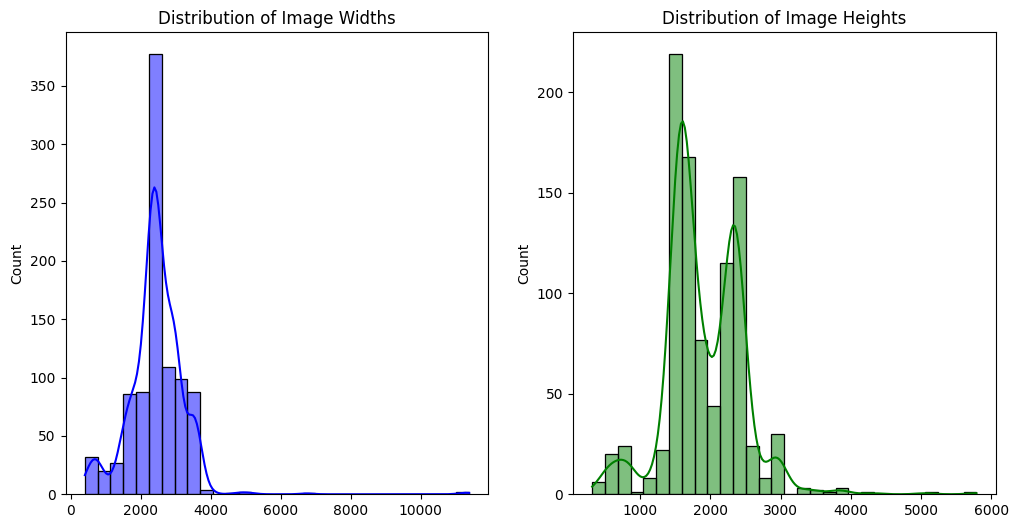

In [12]:
def plot_image_size_distribution(folder):
    widths, heights = [], []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        widths.append(img.width)
                        heights.append(img.height)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(widths, bins=30, kde=True, color='blue')
    plt.title("Distribution of Image Widths")

    plt.subplot(1, 2, 2)
    sns.histplot(heights, bins=30, kde=True, color='green')
    plt.title("Distribution of Image Heights")

    plt.show()

# Path to the folder containing images
folder_path = r'C:\Users\uu1n23\Downloads\DeduplicationFinal'
plot_image_size_distribution(folder_path)


In [20]:
def extract_features(img, model):
    """Extract features using the customized Xception model."""
    return model.predict(img)

def find_duplicate_images(folder, model, target_size=(299, 299)):
    """Find duplicate images in a folder based on feature similarity."""
    
    feature_list = []
    file_paths = []

    # Traverse the directory
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        rgb_img = convert_to_rgb(img)
                        preprocessed_img = preprocess_image(rgb_img, target_size)
                    img_features = extract_features(preprocessed_img, model).flatten()
                    
                    feature_list.append(img_features)
                    file_paths.append(file_path)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    # Normalize features and reduce dimensionality
    feature_list = np.array(feature_list)
    pca = PCA(n_components=50)  # Reduce dimensions to 50 components
    reduced_features = pca.fit_transform(feature_list)

    # Calculate cosine similarity between feature vectors
    similarity_matrix = cosine_similarity(reduced_features)
    threshold = 0.9  # Adjust this threshold based on your needs
    
    # Identify duplicates based on similarity
    duplicates = []
    visited = set()
    
    for i in range(len(file_paths)):
        if i in visited:
            continue
        group = [file_paths[i]]
        visited.add(i)
        for j in range(i + 1, len(file_paths)):
            if similarity_matrix[i, j] > threshold:
                group.append(file_paths[j])
                visited.add(j)
        if len(group) > 1:
            duplicates.append(group)

    return duplicates, similarity_matrix, pca

duplicate_pairs, similarity_matrix, pca = find_duplicate_images(folder_path, model)

print("Duplicate image groups:")
for group in duplicate_pairs:
    print(group)


1/1 [==============================] - 0s 94ms/step


c:\Users\uu1n23\Downloads\hsshing\.venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


1/1 [==============================] - 0s 87ms/step


c:\Users\uu1n23\Downloads\hsshing\.venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1/1 [==============================] - 0s 100ms/step
Duplicate image groups:
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_006_74.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\RMM 1974_6.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_006_74.tif']
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_008_71.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_008_71 - Copy.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_008_71.tif']
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_008_74.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\RMM 1974_8.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_008_74.tif']
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_009_74.tif', 'C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\Art\\hmp_rmmus_009_74.tif']
['C:\\Users\\uu1n23\\Downloads\\DeduplicationFinal\\hmp_rmmus_010_74.tif', 'C:\\Users

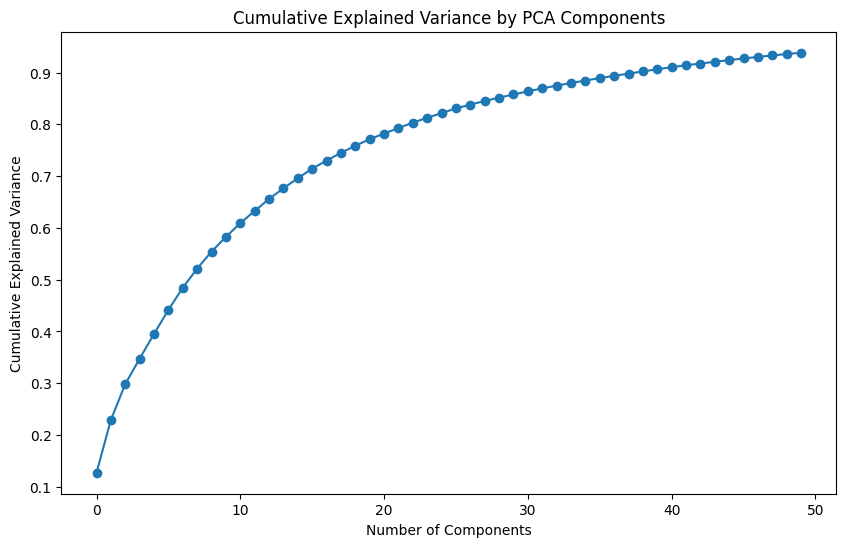

In [14]:
def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title("Cumulative Explained Variance by PCA Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.show()

plot_pca_variance(pca)


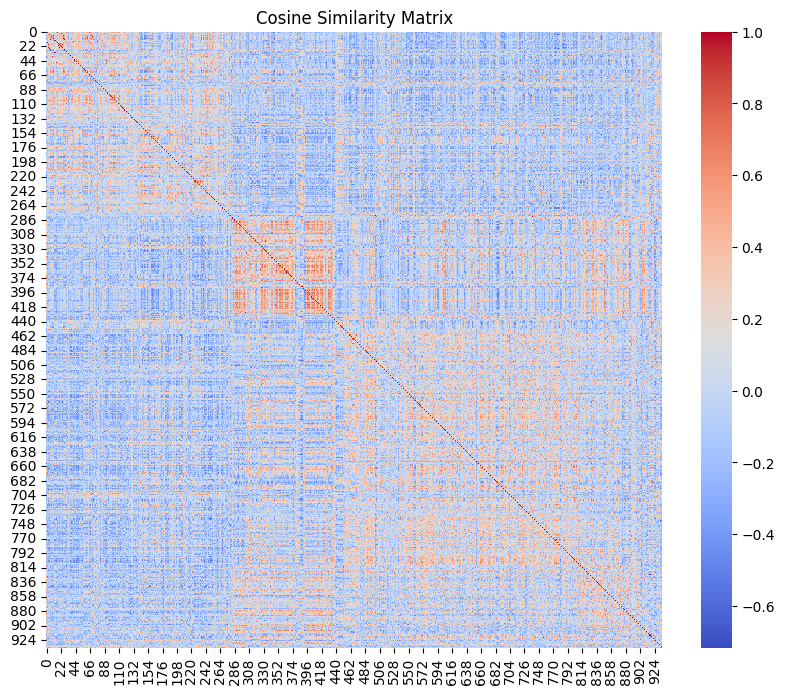

In [15]:
def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='coolwarm', square=True)
    plt.title("Cosine Similarity Matrix")
    plt.show()

plot_similarity_matrix(similarity_matrix)


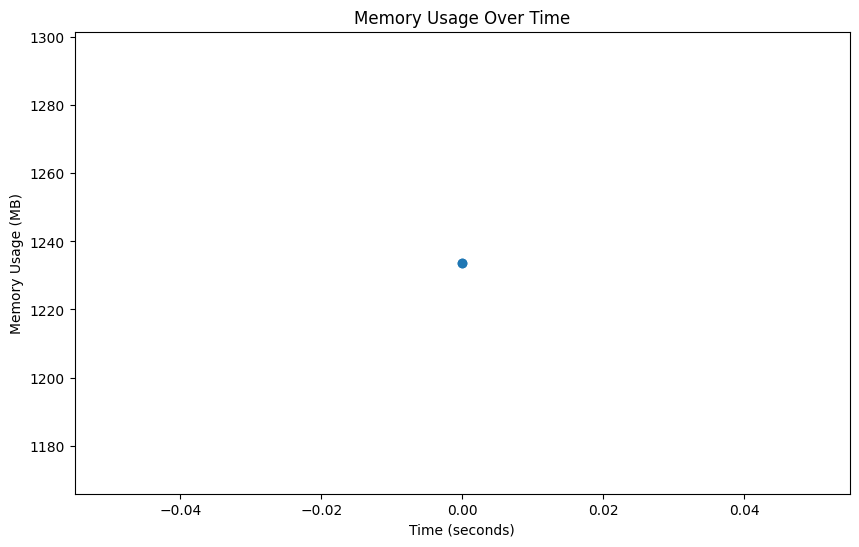

In [16]:
def measure_memory_usage():
    """Measure the current memory usage of the process."""
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
    return memory_usage

def plot_memory_usage(memory_before, memory_after, elapsed_time):
    plt.figure(figsize=(10, 6))
    plt.plot([0, elapsed_time], [memory_before, memory_after], marker='o')
    plt.title("Memory Usage Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Memory Usage (MB)")
    plt.show()

memory_before = measure_memory_usage()
start_time = time.time()

# Your processing code here...

end_time = time.time()
elapsed_time = end_time - start_time
memory_after = measure_memory_usage()

plot_memory_usage(memory_before, memory_after, elapsed_time)


In [21]:
def calculate_accuracy(ground_truth, duplicate_pairs):
    # Convert ground truth pairs to a set of tuples without paths
    ground_truth_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in ground_truth)
    
    # Convert detected pairs to a set of tuples without paths
    detected_pairs_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in duplicate_pairs)
    
    # Calculate intersection (common pairs)
    common_pairs = ground_truth_set.intersection(detected_pairs_set)
    
    # Calculate accuracy as the ratio of correctly detected pairs to total ground truth pairs
    accuracy = len(common_pairs) / len(ground_truth)
    
    return accuracy
if __name__ == "__main__":
    # Your ground truth pairs
    ground_truth =  [
    ('hmp_rmmus_011_74.tif', 'RMM 1974_11.tif'),
    ('RMM 1974_13.tif', 'RMM 1974_13_o2.jpg'),
    ('hmp_rmmus_006_74.tif', 'RMM 1974_6.tif'),
    ('RMM 1974_7.tif', 'RMM 1974_7_o4.jpg'),
    ('hmp_rmmus_008_74.tif', 'RMM 1974_8.tif'),
    ('hmp_rmmus_006_74.tif', 'hmp_rmmus_006_74.tif'),
    ('RMM 1974_7.tif', 'hmp_rmmus_007_74.tif'),
    ('hmp_rmmus_008_71.tif', 'hmp_rmmus_008_71 - Copy.tif'),
    ('hmp_rmmus_008_71.tif', 'hmp_rmmus_008_71.tif'),
    ('hmp_rmmus_008_74.tif', 'hmp_rmmus_008_74.tif'),
    ('hmp_rmmus_009_74.tif', 'hmp_rmmus_009_74.tif'),
    ('hmp_rmmus_010_74.tif', 'hmp_rmmus_010_74.tif'),
    ('hmp_rmmus_011_74.tif', 'hmp_rmmus_011_74.tif'),
    ('RMM 1974_13.tif', 'hmp_rmmus_13_74.tif'),
    ('RMM 1973_170.tif', 'hmp_rmmus_170_73.tif'),
    ('RMM 1974_19.tif', 'hmp_rmmus_19_74.tif'),
    ('RMM 1974_20.tif', 'hmp_rmmus_20_74.tif'),
    ('RMM 1971_278.tif', 'hmp_rmmus_278_71.tif'),
    ('RMM 1967_304.tif', 'hmp_rmmus_304_67.tif'),
    ('hmp_rmmus_88_02o - Copy.tif', 'hmp_rmmus_88_02o.tif'),
    ('hmp_rmmus_88_02t.tif', 'hmp_rmmus_88_02ta.tif'),
    ('NMRN  2017_106_178_unframed.jpg', 'NMRN  2017_106_178_unframed.tif'),
    ('NMRN 2016_26_5 Commander Daniel Little Couch.jpg', 'NMRN 2016_26_5 Commander Daniel Little Couch.tif'),
    ('NMRN 2016_29_1 Cdr Crooke RNR low res.jpg', 'NMRN 2016_29_1 Cdr Crooke RNR.jpg'),
    ('RNM 1982_1572 - Copy.tif', 'RNM 1982_1572.tif'),
    ('RNM 2000_45_1 - Copy.tif', 'RNM 2000_45_1.tif'),
    ('Cardiff - Copy.jpg', 'Cardiff.jpg'),
    ('Exeter(2) - Copy.jpg', 'Exeter(2).jpg'),
    ('Exeter(8) - Copy.jpg', 'Exeter(8).jpg'),
    ('Glasgow(1) - Copy.jpg', 'Glasgow(1).jpg'),
    ('Black Rover(4).jpg', 'Black Rover(4).jpg'),
    ('Regent(3).jpg', 'Regent(3).jpg'),
    ('Achiles(1) - Copy.jpg', 'Achiles(1).jpg'),
    ('Phoebe(1) - Copy.jpg', 'Phoebe(1).jpg'),
    ('Sirius(2).jpg', 'Sirius(2).jpg'),
    ('Sirius(5) - Copy.jpg', 'Sirius(5).jpg'),
    ('Theseus.jpg', 'Theseus.jpg'),
    ('St Austell.jpg', 'St Austell.jpg'),
    ('London(1) - Copy.jpg', 'London(1).jpg'),
    ('Sheffield(6) - Copy.jpg', 'Sheffield(6).jpg'),
    ('Fearless.jpg', 'Fearless.jpg'),
    ('Lynx-1.jpg', 'Lynx-1.jpg'),
    ('Argus-1.jpg', 'Argus-1.jpg'),
    ('Brinton.jpg', 'Brinton.jpg'),
    ('Active-1.jpg', 'Amazon-1.jpg'),
    ('Exeter-2.jpg', 'Liverpool-2.jpg'),
    ('Sheffield-1.jpg', 'Sheffield-1.jpg'),
    ('Bangor - Copy.jpg', 'Bangor - Copy.jpg'),
    ('Bangor - Copy.jpg', 'Bangor.jpg'),
    ('Cumberland.jpg', 'Cumberland.jpg'),
    ('Gloucester.jpg', 'Gloucester.jpg')
]
# Calculate accuracy
accuracy = calculate_accuracy(ground_truth, duplicate_pairs)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 80.39%


In [22]:
from sklearn.metrics import jaccard_score

def calculate_jaccard_index(ground_truth, duplicate_pairs):
    ground_truth_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in ground_truth)
    detected_pairs_set = set((os.path.basename(pair[0]), os.path.basename(pair[1])) for pair in duplicate_pairs)
    
    y_true = []
    y_pred = []

    for pair in ground_truth_set:
        y_true.append(1)
        y_pred.append(1 if pair in detected_pairs_set else 0)
    
    for pair in detected_pairs_set - ground_truth_set:
        y_true.append(0)
        y_pred.append(1)
    
    jaccard = jaccard_score(y_true, y_pred)
    return jaccard

jaccard_index = calculate_jaccard_index(ground_truth, duplicate_pairs)
print(f"Jaccard Index: {jaccard_index:.2f}")


Jaccard Index: 0.56
